<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/Data%20Processing/Prepare_train_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook trains an simple PPG DNN by using labeled PPG data from BP_Data_Clean notebook;
The loaded data is 60s segemented PPG signals with 125Hz sampling rate.

#2.Setup Environment



In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
from wfdb import processing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle

#3.Prepare train, val and test data

In [2]:
#ratio value is between 0 and 1
#make sure seed is set to a same number for repeatable results\
#or to compare models apple to apple
def slice_dataset(dataset,labels,train_ratio,seed = 20):  
  DATASET_SIZE =len(list(dataset)) #only works in eager mode (e.g. TF version >= 2.0.x)
  train_size = int(train_ratio * DATASET_SIZE)
  val_size = DATASET_SIZE - train_size
  
  np.random.seed(seed=seed)
  np.random.shuffle(dataset)
  train_dataset = dataset[:train_size,:,:]
  val_dataset = dataset[-val_size:,:,:]

  np.random.seed(seed=seed)
  np.random.shuffle(labels)
  train_labels = labels[:train_size,:]
  val_labels = labels[-val_size:,:]

  return train_dataset,val_dataset,train_labels, val_labels

In [3]:
"""
this function shuffle a list on a random seed, and slice the list on an input ratio,
it returns two sliced numpy arrays
"""
def shuffle_split_list(list, seed, ratio):
  list_array = np.asarray(list)
  np.random.seed(seed = seed)
  np.random.shuffle(list_array)
  train = list_array[int(len(list_array)*ratio):]
  test = list_array[:int(len(list_array)*ratio)]
  return train, test

In [6]:
directory = 'D:/WFDB/matched/BP/new patient BP data/'
PPG_names = glob.glob(directory + "data/new*")
label_names = glob.glob(directory + "label/new*")

assert(len(PPG_names) == len(label_names))

In [8]:
fn_data_train, fn_data_test = shuffle_split_list(PPG_names,seed = 20,ratio = 0.05)

In [11]:
range(len(fn_data_train))

range(0, 1788)

In [12]:
with open(fn_data_train[10], "rb") as fp:
  raw_signals = pickle.load(fp)

In [18]:
range(len(raw_signals))

range(0, 1596)

In [20]:
wfdb.processing.resample_sig(raw_signals[1595],125,125)

(array([ 0.00053891,  0.00424535,  0.01639663, ..., -0.52217218,
        -0.51176384, -0.49950831]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 7.497e+03, 7.498e+03,
        7.499e+03]))

In [34]:
os.path.getsize(fn_data_train[1788])

IndexError: ignored

In [37]:
"""
p_Resample_reshape_slice_data:
#1.Resample the data from original 125Hz to specified frequency (sf)
#2.reshape the data from [NONE, 60*sampling frequency(sf)] to [NONE,ts,60*sf/ts,1] 
#  (e.g.from [NONE, 7500] to [NONE, 10, 750, 1]), where 60*sf/ts mush be an positive integer
#3.Create train,validation and test dataset

#input:
#     sf: sampling frequency, if other than orginal 125Hz
#     ts: timesteps that define how many images/signals were fed into LSTM
#     t_ratio: test dataset ratio to (train+validation) dataset
#     val_ratio: validation dataset ratio to train dataset

#output:
#     save reshaped and shuffled dataset per 1min into train,validatin,test folders that are
#     created **BEFORE** calling this function
"""
def p_resample_reshape_slice_data(directory,sf = 125, ts=6,t_ratio = 0.05, val_ratio = 0.1):  
  
  #load data
  PPG_names = glob.glob(directory + "data/new*")
  label_names = glob.glob(directory + "label/new*")
  
  assert(len(PPG_names) == len(label_names))

  #shuffle filenames
  fn_data_train, fn_data_test = shuffle_split_list(PPG_names,seed = 20,ratio = t_ratio)
  fn_label_train, fn_label_test = shuffle_split_list(label_names,seed = 20,ratio = t_ratio)
  
  #create train and validation dataset and labels
  numer_of_patient_train = 0
  for i in range(len(fn_data_train)):

    if os.path.getsize(fn_data_train[i]) < 5*1024: continue

    with open(fn_data_train[i], "rb") as fp:
      raw_signals = pickle.load(fp)
    with open(fn_label_train[i], "rb") as fp:
      raw_labels = pickle.load(fp)
    
    #resample to specified frequency sf
    resamp_PPG_signals = []
    
    for k in range(len(raw_signals)):
      resamp_PPG_signal, _ = wfdb.processing.resample_sig(raw_signals[k],125,sf)
      resamp_PPG_signals.append(resamp_PPG_signal)

  #create the right dim for signals
    raw_signals = np.array(resamp_PPG_signals)
    raw_signals = np.reshape(raw_signals,[len(raw_signals),ts,int(60*sf/ts)])
    raw_signals = np.expand_dims(raw_signals, axis=3)
    raw_labels = np.array(raw_labels)

    train_dataset, val_dataset, train_labels, val_labels  = slice_dataset(raw_signals,raw_labels,1-val_ratio)

    with open(directory + "train/"+"data_" + str(i), "wb") as fp:
      pickle.dump(train_dataset,fp)
    
    with open(directory + "train/"+"label_" + str(i), "wb") as fp:
      pickle.dump(train_labels,fp)    
    
    with open(directory + "validation/"+"data_" + str(i), "wb") as fp:
      pickle.dump(val_dataset,fp)
    
    with open(directory + "validation/"+"label_" + str(i), "wb") as fp:
      pickle.dump(val_labels,fp)                
      
    numer_of_patient_train += 1

  #create test dataset and labels
  numer_of_patient_test = 0
  for i in range(len(fn_data_test)):
    
    if os.path.getsize(fn_data_test[i]) < 5*1024: continue

    with open(fn_data_test[i], "rb") as fp:
      raw_signals = pickle.load(fp)
    with open(fn_label_test[i], "rb") as fp:
      raw_labels = pickle.load(fp)

    #resample to specified frequency sf
    resamp_PPG_signals = []
    for k in range(len(raw_signals)):
      resamp_PPG_signal, _ = wfdb.processing.resample_sig(raw_signals[k],125,sf)
      resamp_PPG_signals.append(resamp_PPG_signal)

    #create the right dim for signals
    raw_signals = np.array(resamp_PPG_signals)
    raw_signals = np.reshape(raw_signals,[len(raw_signals),ts,int(60*sf/ts)])
    raw_signals = np.expand_dims(raw_signals, axis=3)
    raw_labels = np.array(raw_labels)

    with open(directory + "test/"+"data_" + str(i), "wb") as fp:
      pickle.dump(raw_signals,fp)
    
    with open(directory + "test/"+"label_" + str(i), "wb") as fp:
      pickle.dump(raw_labels,fp)

    numer_of_patient_test += 1

  print('There are:', numer_of_patient_train, 'patients in training/validation dataset')
  print('There are:', numer_of_patient_test, 'patients in test dataset')
  return None

In [38]:
directory = 'D:/WFDB/matched/BP/new patient BP data/'
p_resample_reshape_slice_data(directory, sf=125, ts=6, t_ratio=0.05, val_ratio=0.1)

There are: 1025 in training/validation dataset
There are: 47 in test dataset


In [155]:
"""
Resample_reshape_slice_data:
#1.Resample the data from original 125Hz to specified frequency (sf)
#2.reshape the data from [NONE, 60*sampling frequency(sf)] to [NONE,ts,60*sf/ts,1] 
#  (e.g.from [NONE, 7500] to [NONE, 10, 750, 1]), where 60*sf/ts mush be an positive integer
#3.Create train,validation and test dataset

#input:
#     sf: sampling frequency, if other than orginal 125Hz
#     ts: timesteps that define how many images/signals were fed into LSTM
#     t_ratio: test dataset ratio to (train+validation) dataset
#     val_ratio: validation dataset ratio to train dataset

#output:
#     save reshaped and shuffled dataset per 1min into train,validatin,test folders that are
#     created **BEFORE** calling this function
"""

def resample_reshape_slice_data(directory,sf = 125, ts=6,t_ratio = 0.05, val_ratio = 0.1):
  #load data
  PPG_names = glob.glob(directory + "BP_data*")
  label_names = glob.glob(directory + "BP_label*")
  
  assert(len(PPG_names) == len(label_names))

  for i in range(len(PPG_names)):  
    #skip in case there is empty fil
    if os.path.getsize(PPG_names[i]) < 5*1024: continue

    print("processing", i, "th data")

    with open(PPG_names[i], "rb") as fp:
      raw_signals = pickle.load(fp)

    with open(label_names[i], "rb") as fp:
      raw_labels = pickle.load(fp)

    
    #resample to specified frequency sf
    
    resamp_PPG_signals = []
    for k in range(len(raw_signals)):
      resamp_PPG_signal, _ = wfdb.processing.resample_sig(raw_signals[k],125,sf)
      resamp_PPG_signals.append(resamp_PPG_signal)

    #create the right dim for signals
    raw_signals = np.array(resamp_PPG_signals)
    raw_signals = np.reshape(raw_signals,[len(raw_signals),ts,int(60*sf/ts)])
    raw_signals = np.expand_dims(raw_signals, axis=3)
    raw_labels = np.array(raw_labels)

    train_dataset, test_dataset, train_labels, test_labels  = slice_dataset(raw_signals,raw_labels,1-t_ratio)
    train_dataset, val_dataset, train_labels, val_labels  = slice_dataset(train_dataset,train_labels,1-val_ratio)

    with open(directory + "train/"+"data_" + str(i), "wb") as fp:
      pickle.dump(train_dataset,fp)
    
    with open(directory + "train/"+"label_" + str(i), "wb") as fp:
      pickle.dump(train_labels,fp)    
    
    with open(directory + "validation/"+"data_" + str(i), "wb") as fp:
      pickle.dump(val_dataset,fp)
    
    with open(directory + "validation/"+"label_" + str(i), "wb") as fp:
      pickle.dump(val_labels,fp)                
    
    with open(directory + "test/"+"data_" + str(i), "wb") as fp:
      pickle.dump(test_dataset,fp)
    
    with open(directory + "test/"+"label_" + str(i), "wb") as fp:
      pickle.dump(test_labels,fp)  

  return None

#4.Check BP distribution




In [39]:
#concatenate label
def concatenate_label(directory):
  raw_labels_list = []

  for name in glob.glob(directory):

    with open(name, "rb") as fp:
      raw_label = pickle.load(fp)
    
    raw_labels_list.append(raw_label)
  
  raw_labels = [y for x in raw_labels_list for y in x]
    
  return raw_labels

In [40]:
directory = 'D:/WFDB/matched/BP/new patient BP data/'
train_dir = directory + "train/label*"
train_labels = concatenate_label(train_dir)
train_labels = np.array(train_labels)

Systolic BP has a mean value of: 131.0 and a STD of: 22.5
Diastolic BP has a mean value of: 59.3 and a STD of: 12.2


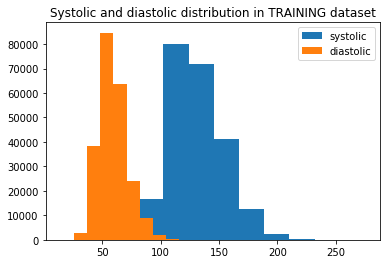

In [41]:
#check sys and dia distribution in train dataset
plt.title("Systolic and diastolic distribution in TRAINING dataset")
plt.hist(train_labels[:,0], label="systolic")
plt.hist(train_labels[:,1],label="diastolic")
plt.legend()
sys_std = round(np.std(train_labels[:,0]),1)
sys_mean = round(np.mean(train_labels[:,0]),1)
print("Systolic BP has a mean value of:", sys_mean, "and a STD of:", sys_std)
dia_std = round(np.std(train_labels[:,1]),1)
dia_mean = round(np.mean(train_labels[:,1]),1)
print("Diastolic BP has a mean value of:", dia_mean, "and a STD of:", dia_std)

In [42]:
directory = 'D:/WFDB/matched/BP/new patient BP data/'
val_dir = directory + "validation/label*"
val_labels = concatenate_label(val_dir)
val_labels = np.array(val_labels)

Systolic BP has a mean value of: 131.0 and a STD of: 22.4
Diastolic BP has a mean value of: 59.3 and a STD of: 12.1


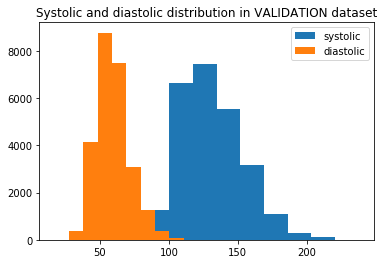

In [43]:
#check sys and dia distribution in validation dataset
plt.title("Systolic and diastolic distribution in VALIDATION dataset")
plt.hist(val_labels[:,0], label="systolic")
plt.hist(val_labels[:,1],label="diastolic")
plt.legend()
sys_std = round(np.std(val_labels[:,0]),1)
sys_mean = round(np.mean(val_labels[:,0]),1)
print("Systolic BP has a mean value of:", sys_mean, "and a STD of:", sys_std)
dia_std = round(np.std(val_labels[:,1]),1)
dia_mean = round(np.mean(val_labels[:,1]),1)
print("Diastolic BP has a mean value of:", dia_mean, "and a STD of:", dia_std)

In [44]:
directory = 'D:/WFDB/matched/BP/new patient BP data/'
test_dir = directory + "test/label*"
test_labels = concatenate_label(test_dir)
test_labels = np.array(test_labels)

Check the distribution of systolic and diastolic BP value

Systolic BP has a mean value of: 137.8 and a STD of: 23.1
Diastolic BP has a mean value of: 59.2 and a STD of: 12.7


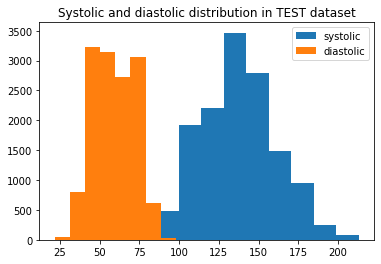

In [45]:
#check sys and dia distribution in test dataset
plt.title("Systolic and diastolic distribution in TEST dataset")
plt.hist(test_labels[:,0], label="systolic")
plt.hist(test_labels[:,1],label="diastolic")
plt.legend()
sys_std = round(np.std(test_labels[:,0]),1)
sys_mean = round(np.mean(test_labels[:,0]),1)
print("Systolic BP has a mean value of:", sys_mean, "and a STD of:", sys_std)
dia_std = round(np.std(test_labels[:,1]),1)
dia_mean = round(np.mean(test_labels[:,1]),1)
print("Diastolic BP has a mean value of:", dia_mean, "and a STD of:", dia_std)

#5.Concatenate Test data and label

In [46]:
#concatenate data
def concatenate_data(directory):
  raw_signals_list = []
  files_list = directory + "data*"
  for name in glob.glob(files_list):
    raw_signal = pickle.load(open(name,'rb'))
    raw_signals_list.append(raw_signal)
  raw_signals = [y for x in raw_signals_list for y in x]
  return raw_signals

In [52]:
#load PPG signal
test_signals = concatenate_data('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/new tvt/test/')

In [53]:
with open("C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/new tvt/test/test_data", "wb") as fp:
  pickle.dump(test_signals, fp)

In [54]:
#concatenate label
def concatenate_label(directory):
  raw_labels_list = []
  files_list = directory + "label*"
  for name in glob.glob(files_list):
    raw_label = pickle.load(open(name,'rb'))
    raw_labels_list.append(raw_label)
  raw_labels = [y for x in raw_labels_list for y in x]
  return raw_labels

In [55]:
test_labels = concatenate_label('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/new tvt/test/')

In [56]:
with open('C:/Users/57lzhang.US04WW4008/Desktop/Blood pressure/BP data/new tvt/test/test_labels', "wb") as fp:
  pickle.dump(test_labels, fp)